### Data Collection and Exploration

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

#Reading the dataset in a dataframe using Pandas
df = pd.read_csv("/Users/philipyoon/python/loan_prediction/train.csv") 

In [35]:
df['Gender']

0        Male
1        Male
2        Male
3        Male
4        Male
        ...  
609    Female
610      Male
611      Male
612      Male
613    Female
Name: Gender, Length: 614, dtype: object

In [36]:
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [37]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


There is a possible skew in the data given that ApplicantIncome's mean is a fair bit away from the median (50% figure).

In [38]:
df['Property_Area'].value_counts() 

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

Given the criteria of giving loans, the most important variables are probably ApplicantIncome and LoanAmount.

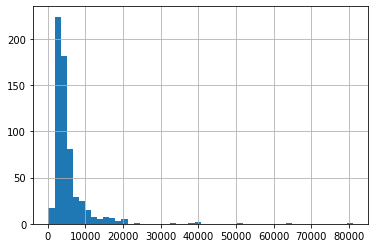

In [39]:
df['ApplicantIncome'].hist(bins=50)

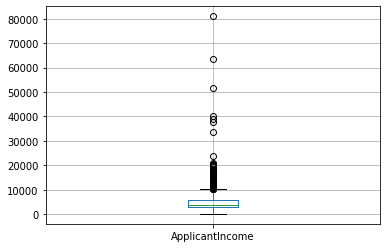

In [40]:
df.boxplot(column='ApplicantIncome')

The histogram and boxplot show there are a fair number of outliers. This can probably be explained by the income disparity in society. Since education levels may explain this disparity, we will segregate them by education.

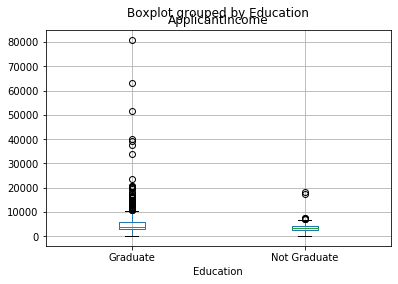

In [41]:
df.boxplot(column='ApplicantIncome', by='Education')

There doesn't seem to be a difference in mean income between the two groups; however, there are a higher number of graduates with high income which account for the outliers. 

Now I'll look at a histogram and boxplot of Loan Amount.

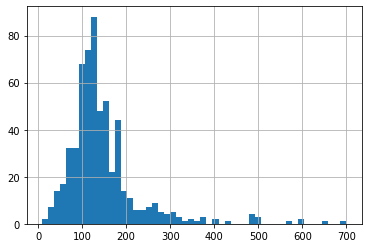

In [42]:
df['LoanAmount'].hist(bins=50)

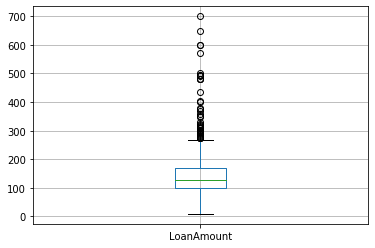

In [43]:
df.boxplot(column='LoanAmount')

Both ApplicantIncome and LoanAmount will require some amount of preprocessing. I will address the missing and extreme values next.

In [44]:
print(df.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [45]:
print((df[:]==0).sum())

Loan_ID                0
Gender                 0
Married                0
Dependents             0
Education              0
Self_Employed          0
ApplicantIncome        0
CoapplicantIncome    273
LoanAmount             0
Loan_Amount_Term       0
Credit_History        89
Property_Area          0
Loan_Status            0
dtype: int64


0's are only a missing value for certain variables, but for CoapplicantIncome and Credit_History it makes sense. 

The simplest option to handle the missing data is to remove the missing value entries.  

In [46]:
df.dropna(inplace=True)

Alternatively, I could have imputed missing values such as replacing NaN by mean.

Now to treat the extreme values in distribution of LoanAmount and ApplicantIncome. First, LoanAmount. Since the extreme values for LoanAmount are technically possible, I won't treat them as outliers but try a log transformation to lessen their effect.

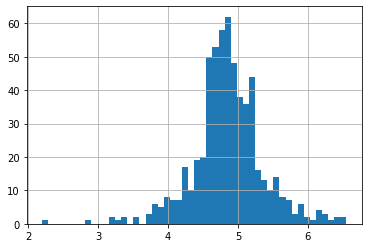

In [28]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=50)

This distribution seems much closer to normal and the effect of extreme LoanAmount has significantly been reduced.

Next, ApplicantIncome. Since some applicants might have lower income but have a lot of support from co-applicants, I will combine both incomes as total income and log transform.

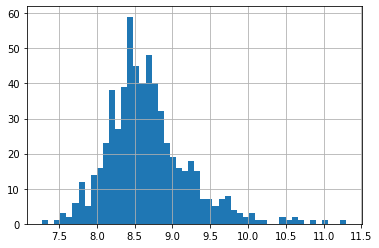

In [32]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=50)

This distribution is much better than before. 

### Modeling
Now that the data useful for modeling, time to build a predictive model on our dataset.

Sklearn requires numeric inputs, so first I will convert the categorical variables into numeric by encoding the categories. 

In [47]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender', 'Married', 'Dependents', 'Education', 
           'Self_Employed', 'Property_Area', 'Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
dtype: object

Next, importing required modules and using a 10 fold cross validation procedure to evaluate the performances of Logistic Regression, SVM, and Decision Tree classifiers. The predictor variables will be Applicant Income, Credit History, and Education and the target variable will be Loan Status. 

In [39]:
#didnt work bc all numbers were the same?
#from sklearn.tree import DecisionTreeClassifier, export_graphviz
#cross_validate(DecisionTreeClassifier(), 
#                                 df[['Credit_History']], 
#                                 df['Loan_Status'], cv = 5)

#cross_validate(LogisticRegression(), 
#                                df[['Credit_History']], 
#                                df['Loan_Status'], cv=5)
#https://www.youtube.com/watch?v=gJo0uNL-5Qw                                


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import metrics

# df.drop(['Loan_ID'],axis=1, inplace=True)
# drop Loan_ID bc its non_numerical

# preparing models 
models = []
models.append(('LR', LogisticRegression()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('SVM', SVC()))

results = []
names = []
seed = 7 # ensures same splits to the training data
x = df[['ApplicantIncome', 'Credit_History', 'Education']]
y = df['Loan_Status']

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.875615 (0.034280)
DTC: 0.769735 (0.048933)
SVM: 0.794945 (0.031202)


Here we see the mean f1 score and the standard deviation of that score for each model after cross validation. I use f1 score because the class distribution is not equal for our target variable, therefore I wouldn't want to use accuracy.

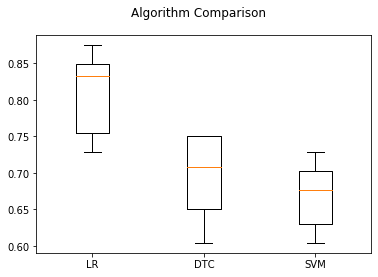

In [57]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Logistic regression seems to have performed well compared to worse results from the decision tree and SVM algorithm. I will now deploy the Logistic Regression model to flask, first pickling the object. 

In [62]:
import pickle

model = LogisticRegression()
model.fit(x,y)
pickle.dump(model, open('model.pkl', 'wb'))